<a href="https://colab.research.google.com/github/MayaHayat/Intel_Classification/blob/main/Intel_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intel Image Classification

By Aviya Oren and Maya Hayat

This Data contains around 25k images of size 150x150 distributed under 6 categories.
1. 'buildings'
2. 'forest'
3. 'glacier'
4. 'mountain'
5. 'sea'
6. 'street'

In [ ]:
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from PIL import Image
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import random

import cv2
import imghdr
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

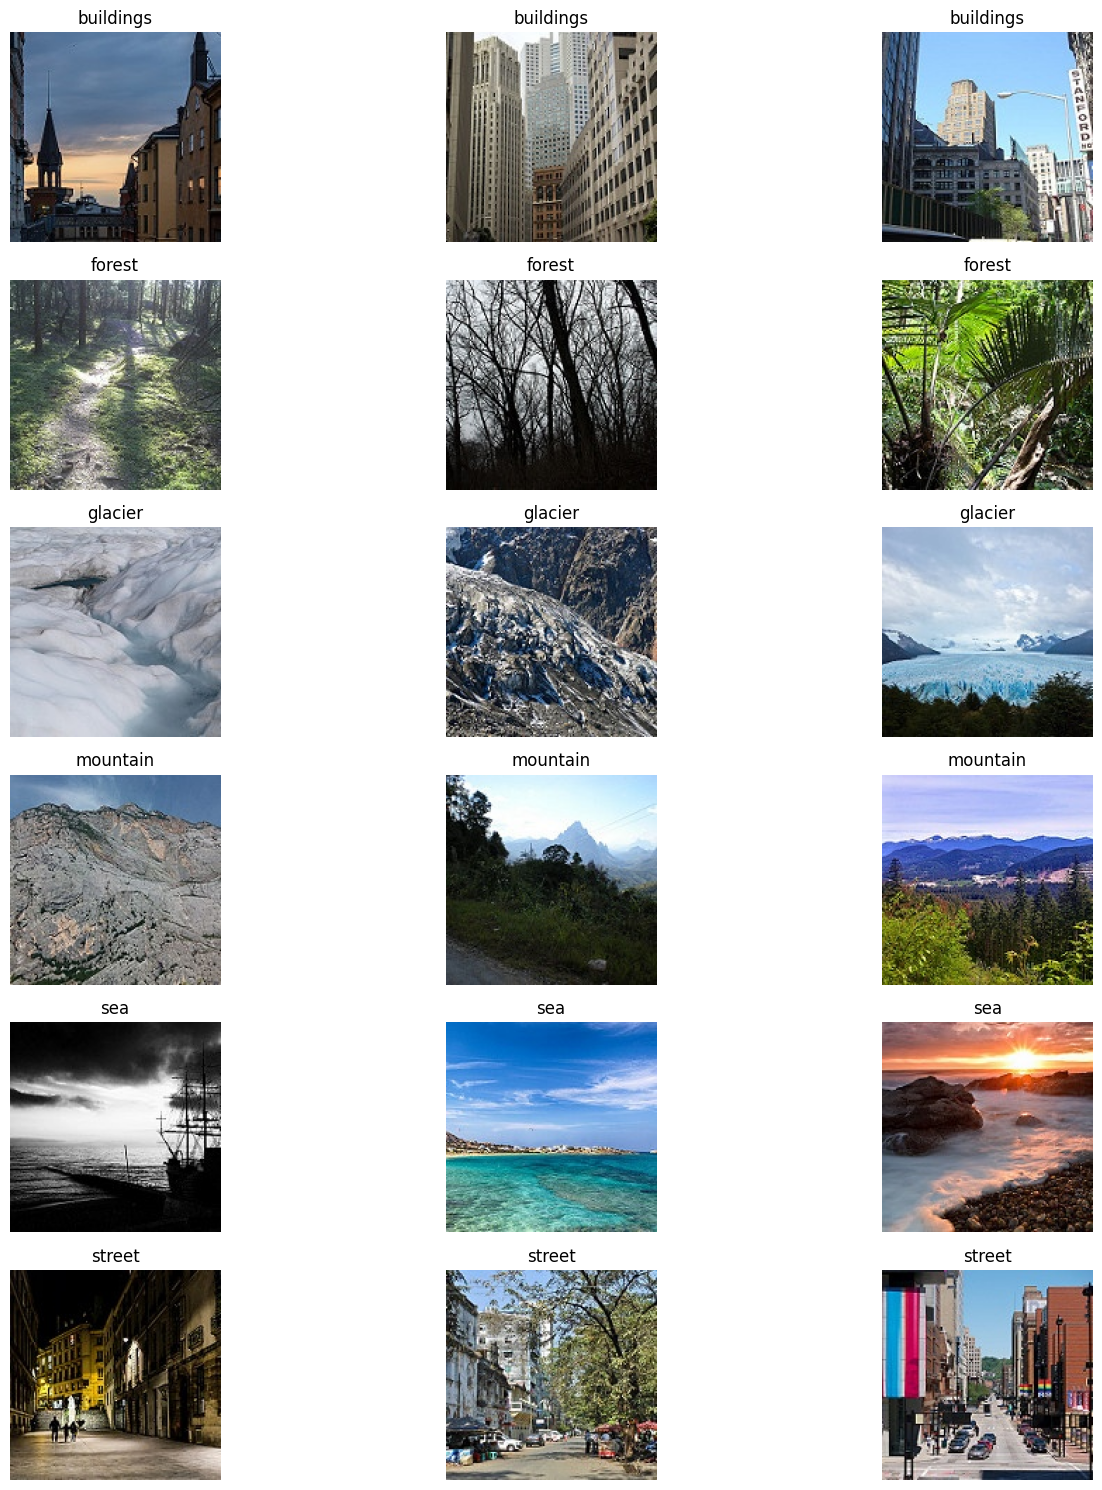

In [25]:
# Path to the directory containing the images
base_directory = '/content/drive/MyDrive/IntelClassification/seg_train'

# Categories
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Display three random images for each category
fig, axs = plt.subplots(len(categories), 3, figsize=(15, 15))

for i, category in enumerate(categories):
    category_directory = os.path.join(base_directory, category)
    files = os.listdir(category_directory)
    image_files = [file for file in files if file.endswith(('png', 'jpg', 'jpeg'))]
    random_images = random.sample(image_files, 3)

    for j, image_file in enumerate(random_images):
        image_path = os.path.join(category_directory, image_file)
        image = mpimg.imread(image_path)
        axs[i, j].imshow(image)
        axs[i, j].axis('off')
        axs[i, j].set_title(category)

plt.tight_layout()
plt.show()


In [26]:
data_directory = '/content/drive/MyDrive/IntelClassification/seg_train'

In [27]:
os.listdir(data_directory)

['forest', 'buildings', 'street', 'sea', 'mountain', 'glacier']

In [28]:
# According to Kaggle the original size if 150*150, therefore we want to keep it as is
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/IntelClassification/seg_train', image_size = (150,150))

Found 14034 files belonging to 6 classes.


In [29]:
data_iterator = data.as_numpy_iterator()

In [30]:
batch = data_iterator.next()

In [ ]:
# where the first batch is our data and the second is the labels
len(batch)

2

In [ ]:
batch[0].shape

(32, 150, 150, 3)

In [ ]:
batch[1]

array([2, 2, 0, 3, 1, 4, 5, 1, 4, 1, 3, 5, 0, 0, 2, 5, 2, 4, 5, 5, 0, 0,
       0, 2, 3, 0, 4, 1, 3, 3, 4, 5], dtype=int32)

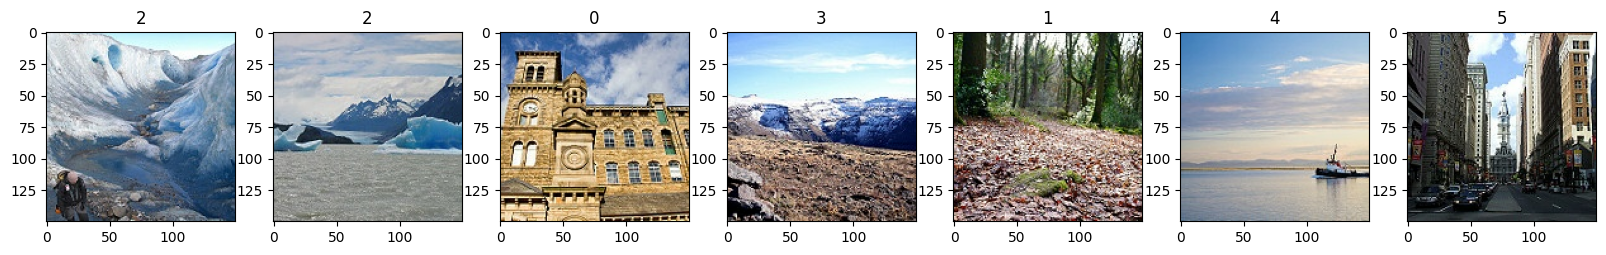

In [ ]:
fig, ax = plt.subplots(ncols=7, figsize=(20,20))
for idx, img in enumerate(batch[0][:7]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

As we can see above the following numbers match the following catagories:
0. building
1. forest
2. glacier
3. mountain
4. sea
5. street

In [31]:
print("max:" , batch[0].max(), " and min: ", batch[0].min())

max: 255.0  and min:  0.0


In [32]:
data = data.map(lambda x, y: (x / 255.0, y))


In [33]:
data.as_numpy_iterator().next()[0].max(), data.as_numpy_iterator().next()[0].min()

(1.0, 0.0)

In [34]:
# Number of batches * 32 images
len(data)

439

In [59]:
train_size = int(len(data)*0.6)+2
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.2)
print("train size:" , train_size, ",test size:", test_size,",val size:", val_size)

train size: 265 ,test size: 87 ,val size: 87


In [60]:
train = data.take(train_size)
test = data.skip(train_size).take(test_size)
val = data.skip(train_size + test_size).take(val_size)

In [61]:
len(train)

265

In [62]:
model= tf.keras.Sequential([
    # First layer
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    # Second layer
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Third layer
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [63]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [64]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 32)        18464     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 17, 17, 32)       

In [65]:
logdir = '/content/drive/MyDrive/IntelClassification/logs'

In [51]:
callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [66]:
history = model.fit(train, epochs=8, validation_data = val, callbacks=[callback])

Epoch 1/8
265/265 [==============================] - 583s 2s/step - loss: 1.0806 - accuracy: 0.5710 - val_loss: 0.8056 - val_accuracy: 0.6942
Epoch 2/8
265/265 [==============================] - 375s 1s/step - loss: 0.7508 - accuracy: 0.7147 - val_loss: 0.7209 - val_accuracy: 0.7404
Epoch 3/8
265/265 [==============================] - 376s 1s/step - loss: 0.6261 - accuracy: 0.7650 - val_loss: 0.6683 - val_accuracy: 0.7505
Epoch 4/8
265/265 [==============================] - 359s 1s/step - loss: 0.5270 - accuracy: 0.8074 - val_loss: 0.6168 - val_accuracy: 0.7733
Epoch 5/8
265/265 [==============================] - 359s 1s/step - loss: 0.4118 - accuracy: 0.8473 - val_loss: 0.5850 - val_accuracy: 0.8007
Epoch 6/8
265/265 [==============================] - 374s 1s/step - loss: 0.3064 - accuracy: 0.8917 - val_loss: 0.6679 - val_accuracy: 0.7841
Epoch 7/8
265/265 [==============================] - 361s 1s/step - loss: 0.2347 - accuracy: 0.9192 - val_loss: 0.7635 - val_accuracy: 0.7838
Epoch 

In [67]:
model.save('first_model_8epc.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
# Load the saved model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/IntelClassification/first_model_8epc.h5')

In [68]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

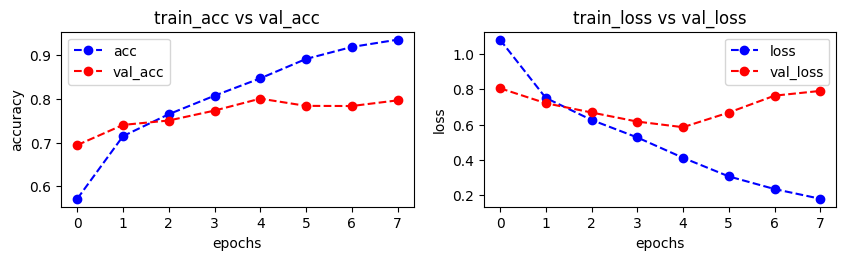

In [69]:
plot_accuracy_loss(history)

In [70]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    y_pred = np.argmax(yhat, axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    acc.update_state(y, y_pred)


1/1 [==============================] - 0s 308ms/step


In [71]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy: {:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.9477, Recall: 0.9648, Accuracy: 0.2820
